## **Model summary**
---

Here we compare the models (again but more in detail and nicely). Some of the process has been already done in GLM-HMM-fitting-Jupyter notebooks, but the main aim of this notebooks is to allow users to do more exploratory analysis.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn import preprocessing
import json
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sys.path.append('../../2_fit_models/dmdm')
from data_io import get_file_dir, load_animal_list, load_cv_arr, load_data
from data_labels import create_abort_mask, partition_data_by_session
from plot_model_perform import create_cv_frame_for_plotting, plot_state_Wk, plot_state_dwelltime
from plotting_utils import load_glmhmm_result, calc_dwell_time
from plot_animal_behav import plot_PC, plot_CC, plot_FArate
import matplotlib.ticker as ticker

In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

In [3]:
# ------- setup variables -------
dname = 'dataAllMiceTraining'
C = 3  # number of output types/categories
D = 1  # data (observations) dimension
K_vals = [1, 2, 3, 4]
labels_for_plot_y = ['CSize', 'COnset', 'Outcome +1', 'Outcome +2', 'Outcome +3', 'Outcome +4', 'Outcome +5', 'bias']

save_figures = True

In [4]:
# ------- setup path and load data -------
data_2_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster' / "data_by_animal"
results_2_dir = get_file_dir().parents[1] / "results" / "dmdm_individual_fit" / dname
figure_dir = get_file_dir().parents[1] / 'figures'
figure_dir.mkdir(parents=True, exist_ok=True)

# read in data and train/test split
animal_list = load_animal_list(data_2_dir / 'animal_list.npz')

print('Animals fitted: {}'.format(animal_list))

Animals fitted: ['M_AK001' 'M_AK004' 'M_AK005' 'M_AK008' 'M_ML007' 'M_ML008' 'M_ML009']


### Model performance
Similar to Fig. 4A of Ashwood et al., 2022, Nat Neurosci

FileNotFoundError: [Errno 2] No such file or directory: '/nfs/nhome/live/skuroda/Workstation2023/glm-hmm/results/dmdm_individual_fit/dataAllMiceTraining/M_AK001/cvbt_folds_model_GLM_HMM_y.npz'

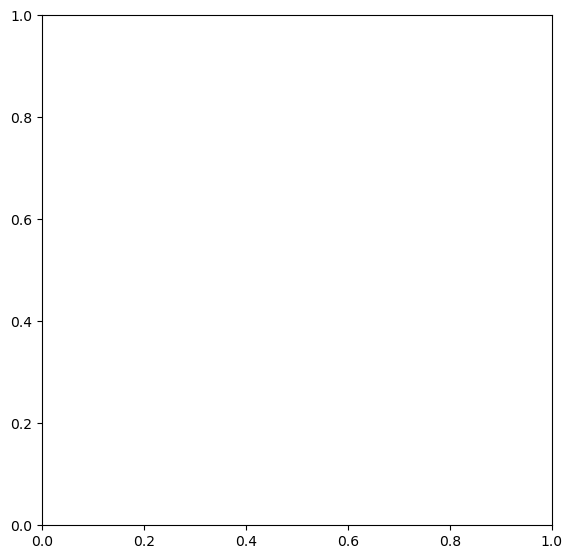

In [5]:
# Each animal
for animal in animal_list:

    # Generate figure
    fig = plt.figure(figsize=(6, 6))
    plt.subplots_adjust(left=0.1,
                        bottom=0.1,
                        right=0.95,
                        top=0.95,
                        wspace=0.45,
                        hspace=0.6)
    ax1= plt.subplot() 

    # Plot normalized LL
    cols = ['#999999', '#984ea3', '#e41a1c', '#dede00']

    this_results_dir = results_2_dir / animal
    cv_arr_GLM_y = load_cv_arr(this_results_dir / "cvbt_folds_model_GLM_y.npz")
    df_GLM_y, _, _ = create_cv_frame_for_plotting(cv_arr_GLM_y)
    df_GLM_y['model'] = -1
    cv_arr_GLM_HMM_y = load_cv_arr(this_results_dir / "cvbt_folds_model_GLM_HMM_y.npz")
    df_GLM_HMM_y, _, _ = create_cv_frame_for_plotting(cv_arr_GLM_HMM_y)
    df_test = pd.concat([df_GLM_y, df_GLM_HMM_y])
    df_test['label'] = 'test'

    cv_train_arr_GLM_y = load_cv_arr(this_results_dir / "cvbt_train_folds_model_GLM_y.npz")
    df_train_GLM_y, _, _ = create_cv_frame_for_plotting(cv_train_arr_GLM_y)
    df_train_GLM_y['model'] = -1
    cv_train_arr_GLM_HMM_y = load_cv_arr(this_results_dir / "cvbt_train_folds_model_GLM_HMM_y.npz")
    df_train_GLM_HMM_y, _, _ = create_cv_frame_for_plotting(cv_train_arr_GLM_HMM_y)
    df_train = pd.concat([df_train_GLM_y, df_train_GLM_HMM_y])
    df_train['label'] = 'training'

    df_all = pd.concat([df_test, df_train])

    y_min = df_train.groupby('model')['cv_bit_trial'].min()[-1]
    df_all['cv_bit_trial'] = df_all['cv_bit_trial'] - y_min

    xrange = [-1, 0, 1, 2, 3, 4]
    meanst = df_all.groupby(['model','label'], as_index=False).agg({'cv_bit_trial': 'mean'})
    sdt = df_all.groupby(['model','label'], as_index=False).agg({'cv_bit_trial': 'std'})
    sns.lineplot(data=df_all, x="model", y="cv_bit_trial", hue="label")

    plt.xticks([-1, 0, 1, 2, 3, 4], ['GLM', '1', '2', '3', '4', '5'],
                fontsize=10)
    plt.ylabel("$\Delta$ test LL (bits/trial)", fontsize=10, labelpad=0)
    plt.xlabel("# states", fontsize=10, labelpad=0)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.ylim((-0.01, 0.24))
    # plt.yticks(color = cols[0])
    leg = plt.legend(fontsize=10,
                        labelspacing=0.05,
                        handlelength=1.4,
                        borderaxespad=0.05,
                        borderpad=0.05,
                        framealpha=0,
                        bbox_to_anchor=(1.2, 0.90),
                        loc='lower right',
                        markerscale=0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(1.0)

    fig.suptitle('GLM_HMM_y LL: {}'.format(animal))

    if save_figures:
        fig.savefig(figure_dir / 'fig_nll_{}.pdf'.format(animal))

    plt.axis('off')
    plt.close(fig)

In [ ]:
# Across animal
fig = plt.figure(figsize=(6, 6))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.95,
                    top=0.95,
                    wspace=0.45,
                    hspace=0.6)

# Plot normalized LL
plt.subplot(1, 2, 1)
cols = ['#999999', '#984ea3', '#e41a1c', '#dede00']
across_animals = []
for animal in animal_list:
    results_dir = overall_dir + animal + '/'
        cvbt_folds_model = load_cv_arr(this_results_dir / "cvbt_folds_model_{}.npz".format(model))

    cv_arr_GLM_y = load_cv_arr(results_dir + "/cvbt_folds_model_GLM_y.npz")
    cv_arr_GLM_HMM_y = load_cv_arr(results_dir + "/cvbt_folds_model_GLM_HMM_y.npz")
    cv_arr_for_plotting = cv_arr[[0, 2, 3, 4, 5, 6], :]
    mean_cvbt = np.median(cv_arr_for_plotting, axis=1) # can be mean?
    across_animals.append(mean_cvbt - mean_cvbt[0])
    mean_cvbt = onp.mean(cvbt_folds_model_tuned, axis=1)
across_animals = np.array(across_animals)
mean_cvbt = np.mean(np.array(across_animals), axis=0)
plt.plot([0, 0.5, 1, 2, 3, 4],
            mean_cvbt - mean_cvbt[0],
            '-o',
            color='k',
            zorder=1,
            alpha=1,
            lw=1.5,
            markersize=4,
            label='mean')
plt.xticks([-1, 0, 1, 2, 3, 4], ['GLM', '1', '2', '3', '4', '5'],
            fontsize=10)
plt.ylabel("$\Delta$ test LL (bits/trial)", fontsize=10, labelpad=0)
plt.xlabel("# states", fontsize=10, labelpad=0)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.ylim((-0.01, 0.24))
# plt.yticks(color = cols[0])
leg = plt.legend(fontsize=10,
                    labelspacing=0.05,
                    handlelength=1.4,
                    borderaxespad=0.05,
                    borderpad=0.05,
                    framealpha=0,
                    bbox_to_anchor=(1.2, 0.90),
                    loc='lower right',
                    markerscale=0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.0)

# Plot prediction accuracy
plt.subplot(1, 2, 1)

if save_figures:
    fig.savefig(figure_dir / 'fig_nll_{}.pdf'.format(animal))

### Behavior for each state
Plot psychometric curve, chronometric curve, and early lick rate for each state within an animal. We also plot dwell time.

In [ ]:
K = 2
model = 'GLM_HMM_y'

In [ ]:
rc_params = {
    'font.sans-serif': ['Arial'],
    'font.size': 8,
    'lines.linewidth': 0.5,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'axes.titlesize': 8,
    'axes.labelsize': 8,
    'xtick.major.size': 1,
    'ytick.major.size': 1
}
sns.set(style='ticks')
sns.set_context('paper', rc=rc_params)
plt.rcParams['pdf.fonttype'] = 'truetype'

In [ ]:
for animal in animal_list:

    states_max_posterior, _, inpt_rt, _, session, _, _, mask, hmm_params \
        = load_glmhmm_result(animal, K, model, results_2_dir, data_2_dir)

    inpt_y, _, y, _, rt, stim_onset = load_data(data_2_dir / (animal + '_unnormalized.npz'))

    data = {'session': session,
            'fitted_trials': np.squeeze(mask),
            'state': states_max_posterior,
            'early_report': np.squeeze(y) == 2, # .astype(int)
            'hit': np.squeeze(y) == 1,
            'miss': np.squeeze(y) == 0,
            'abort': np.squeeze(y) == 3,
            'sig': inpt_y[:,0],
            'rt_change': np.squeeze(rt) - np.squeeze(stim_onset),
            }
    
    # Create DataFrame
    df_all = pd.DataFrame(data)

    fig = plt.figure(constrained_layout = True, figsize=(20/2.54, 4.25/2.54 * K))
    fig.suptitle('GLM_HMM_y: {}'.format(animal))

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=K, ncols=1)
    for row, subfig in enumerate(subfigs):
        zk = row
        subfig.suptitle('State Zk = {}'.format(zk))

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=5)

        # Plot Psychometric/Chronomteric Curve and False Alarm Rate
        plot_PC(df_all, axs[0], label='test data', K=zk)
        axs[0].set_xlabel('Change magnitude \n (octaves)')
        axs[0].set_ylabel('Proportion hits')
        axs[0].set_ylim(0, 1)
        axs[0].set_xlim(0, 2)
        axs[0].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))

        plot_CC(df_all, axs[1], label='test data', K=zk)
        axs[1].set_xlabel('Change magnitude \n (octaves)')
        axs[1].set_ylabel('Reaction time (s)')
        axs[1].axis('tight')
        axs[1].set_xlim(0, 2)
        axs[1].set_ylim(0, 1.5)
        axs[1].yaxis.set_major_locator(ticker.MultipleLocator(0.5))
        axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))

        plot_FArate(df_all, axs[2], label='test data', K=zk)
        axs[2].set_xlabel('Total')
        axs[2].set_ylabel('Early report rate')
        axs[2].axis('tight')
        axs[2].set_xlim(-1, 1)
        axs[2].set_ylim(0, 0.5)
        axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1))

        # Plot GLM weights
        weight_vectors = hmm_params[2][zk]
        plot_state_Wk(weight_vectors,axs[3])
        # axs[3].set_xlabel('Covariate')
        axs[3].set_ylabel('Weight')
        axs[3].legend(bbox_to_anchor=(1, 1.35), 
                    ncol=3,
                    fontsize=5,
                    labelspacing=0.05,
                    framealpha=0,
                    markerscale=0)
        axs[3].axis('tight')
        axs[3].set_xticks(list(range(0, len(labels_for_plot_y))))
        axs[3].set_xticklabels(list(range(0, len(labels_for_plot_y))),
                            rotation=90)
        axs[3].set_xlim(-1, hmm_params[2][zk].shape[1])
        axs[3].set_ylim(-7, 7)

        # Plot dwell time
        dwell_across_sessions = calc_dwell_time(df_all)
        dwell_time_df = dwell_across_sessions[dwell_across_sessions['state'] == zk]
        plot_state_dwelltime(dwell_time_df, axs[4])
        axs[4].set_ylabel('# State changes')
        axs[4].set_xlabel("Dwell time \n (# trials)")
        axs[4].set_ylim(0, 25)
        axs[4].set_xlim(0, 80)
        axs[4].yaxis.set_major_locator(ticker.MultipleLocator(10))
        axs[4].xaxis.set_major_locator(ticker.MultipleLocator(20))
        
    sns.despine(fig, offset=3, trim=False)

    if save_figures:
        fig.savefig(figure_dir / 'fig_state_summary_{}_NumState_{}.pdf'.format(animal, str(K)))

    plt.axis('off')
    plt.close(fig)

In [ ]:
# consider abort states_max_posterior nan